In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial
import tqdm

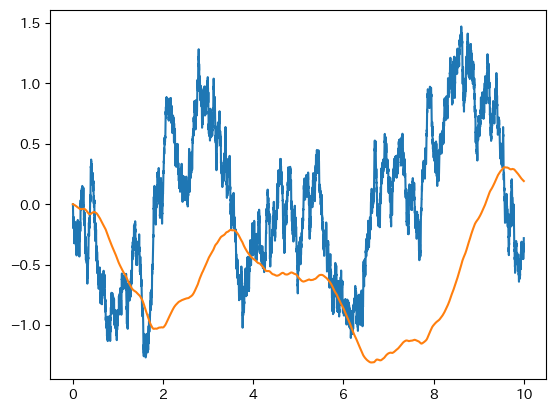

In [4]:
import numpy as np
from scipy.linalg import expm
from scipy.stats import norm

def matrix_exponential(A, t):
    # 固有値と固有ベクトルを計算
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # 固有値の指数行列を作成
    eigenvalues_matrix = np.exp(np.outer(t, eigenvalues))
    # 固有ベクトル行列とその逆行列を計算
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    
    # exp(tA) を計算
    exp_tA = np.einsum('ij,kjl->kil', eigenvectors, eigenvalues_matrix[:, :, np.newaxis] * eigenvectors_inv)
    
    # 実数部分のみを返す
    return np.real(exp_tA)

def linear_Z(theta, t_max, dt, seed):

    np.random.seed(seed)

    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]

    A = np.array([[-theta21, -theta22], [theta3, 0]])
    N = int(t_max / dt)  # ステップ数
    times = np.linspace(0, t_max, N + 1)  # 時間グリッド
    
    # ブラウン運動の増分を生成
    dW = norm.rvs(scale=np.sqrt(dt), size=N)
    
    # 全ての時間に対する行列指数関数を計算
    exp_A_t = matrix_exponential(A, times)
    exp_neg_A_t = matrix_exponential(-A, times[:-1])

    # 積分の計算をベクトル化
    theta_vec = np.array([theta1, 0])
    integrand = np.einsum('ijk,k->ij', exp_neg_A_t, theta_vec) * dW[:,np.newaxis]
    cumulative_integral = np.cumsum(integrand, axis=0)
    
    # 形状を合わせるために初めにゼロベクトルを追加
    cumulative_integral = np.vstack((np.zeros((1, A.shape[0])), cumulative_integral))
    
    # Z_t をループなしで計算
    Z_t = np.einsum('ijk,ik->ij', exp_A_t, cumulative_integral)
    
    return Z_t.T

# 使用例
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.001  # タイムステップの例
seed = 0  # ランダムシードの例

Z_t = linear_Z([1,1,1,1], t_max, dt, 2)
# Z_tの形を(N+1, 2)に変更
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[0])
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[1])

In [5]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]
def compute_b(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    Bn = np.array([np.linalg.matrix_power(B0,n) for n in np.arange(k0+1)])
    x0 = np.array([b0,b1])
    xn = np.einsum('ijk,k->ij',Bn,x0)
    return xn[:,0]

In [6]:
def compute_s(a,theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 )
    l = np.arange(k0 )
    
    m_grid, k_grid,l_grid = np.meshgrid(m, k, l,indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid*valid_mask
    k_grid = k_grid*valid_mask
    l_grid = l_grid*valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1/((m_grid +1)*scipy.special.factorial(k_grid )*scipy.special.factorial(l_grid))
    fact_12 = 1/((m_grid +2)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid))
    fact_22 = 1/((m_grid +3)*scipy.special.factorial(k_grid +1)*scipy.special.factorial(l_grid+1))
    
    mat11 = np.einsum('ijk->i',theta1**2 * a_k * a_l* fact_11)
    mat12 = np.einsum('ijk->i',theta1**2 * theta3  * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i',theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s




In [7]:
import numpy as np
import scipy.special

def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(s[0])
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
        factorial_k = scipy.special.factorial(k -1)
        
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = factorial_k / (scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = scipy.special.factorial(k-1) / scipy.special.factorial(p_valid)
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e


In [8]:
def D(a,b,Z,theta,k0,h):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    Z1 = Z[:,1:]
    Z2 = Z[:,:-1]
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    x_ = x_[:,np.newaxis]
    y_ = y_[:,np.newaxis]
    k = np.arange(1,k0+1)
    f = np.sum((a[k]* x_ + b[k] * y_ )* h**k/scipy.special.factorial(k),axis =1)
    k = np.arange(1,k0+2)
    g = np.sum(theta3*(a[k-1] * x_ +  b[k-1] *y_) * h**k/scipy.special.factorial(k),axis = 1)
    x = Z1[0]
    y = Z1[1]
    x_ = Z2[0]
    y_ = Z2[1]
    Dx = h**(-1/2) *(x - x_ - f)
    Dy = h**(-3/2) *(y - y_ - g)
    return np.array([Dx,Dy])

In [9]:
def QL(Z,theta,k0,h):
    a = compute_a(theta,k0)
    b = compute_b(theta,k0)
    s = compute_s(a,theta,k0)
    d, e = calculate_d_e(s)
    D_ = D(a,b,Z,theta,k0,h)
    k = np.arange(k0+1)
    Q = - np.einsum('k,kj->',h**k, (np.einsum('kpq,pj,qj->kj ',d,D_,D_) + e[:,np.newaxis]))/2
    return Q

In [78]:
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.01  # タイムステップの例
bounds = scipy.optimize.Bounds([0.1,0.1,0.1,0.1],[2,2,2,2])
results1 = []
results2 = []
results3 = []
results4 = []
results5 = []
results10 = []
h = 0.1
for seed in tqdm.tqdm(range(100)):
    Z_t = linear_Z([1,1,1,1], t_max, dt, seed)
    Z = Z_t[:,::int(h/dt)]
    result1 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,1,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result2 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,2,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result3 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,3,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result4 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,4,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result5 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,5,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    result10 = scipy.optimize.minimize(lambda theta: -QL(Z,theta,10,h),[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')
    results1.append(result1.x)
    results2.append(result2.x)
    results3.append(result3.x)
    results4.append(result4.x)
    results5.append(result5.x)
    results10.append(result10.x)
results1 = np.array(results1)
results2 = np.array(results2)
results3 = np.array(results3)
results4 = np.array(results4)
results5 = np.array(results5)
results10 = np.array(results10)



100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


In [79]:
#resultの平均，標準偏差を表にして表示，インデックスがk，カラムがtheta

import pandas as pd
df = pd.DataFrame(np.vstack([np.mean(results1,axis = 0),np.std(results1,axis = 0),np.mean(results2,axis = 0),np.std(results2,axis = 0),np.mean(results3,axis = 0),np.std(results3,axis = 0),np.mean(results4,axis = 0),np.std(results4,axis = 0),np.mean(results5,axis = 0),np.std(results5,axis = 0),np.mean(results10,axis = 0),np.std(results10,axis = 0)]).T)
df.columns = ['k=1 mean','k=1 std','k=2 mean','k=2 std','k=3 mean','k=3 std','k=4 mean','k=4 std','k=5 mean','k=5 std','k=10 mean','k=10 std']
df.index = ['theta1','theta2','theta3','theta4']
df
#インデックスとカラム入れ替え
df = df.T
#dfをcsvファイルに'nh10h10-2QLA.csv'という名前で出力
# df.to_csv('nh100h10-2QLA.csv')
# df.to_csv('nh100h10-1QLA.csv')
df


,theta1,theta2,theta3,theta4
k=1 mean,0.963701,1.100120,1.180316e+00,1.007164
k=1 std,0.045713,0.391231,4.879807e-01,0.013709
k=2 mean,0.944332,1.469047,1.204928e+00,1.008848
k=2 std,0.046099,0.534972,5.081169e-01,0.013910
k=3 mean,0.943834,1.040588,1.246272e+00,1.008072
k=3 std,0.046781,0.337494,4.948553e-01,0.013933
k=4 mean,0.946360,1.728174,1.127406e+00,1.009194
k=4 std,0.046198,0.538185,5.143067e-01,0.013949
k=5 mean,0.944535,1.035599,1.250502e+00,1.007986
k=5 std,0.046442,0.292221,4.951869e-01,0.013850


In [10]:
theta = [1,1,1,1]  
t_max = 100.0  # 最大時間の例
dt = 0.01  # タイムステップの例
Z_t = linear_Z([1,1,1,1], t_max, dt, 2)
h = 0.01
n = t_max//h
Z = Z_t[:,::int(h/dt)]

In [57]:
import numpy as np
import matplotlib.pyplot as plt
k0 = 3

def target_distribution_1(x,alpha,theta21,theta22,theta3,k0,Z):
    if 0.0001 <= x <= 10:
        return np.log(1 / (10 - 0.0001)) + QL(Z, [x, theta21, theta22, theta3], k0, h)/(alpha**2)/(n)
    else:
        return -np.inf
def target_distribution_2(x,alpha,theta1,theta3,k0,Z):
    if np.all((0.0001 <= x[0]) & (x[0] <= 10) & (0.0001 <= x[1]) & (x[1] <= 10)):
        return np.log(1 / (10 - 0.0001)**2) + QL(Z, np.array([theta1, x[0], x[1], theta3]), k0, h)/(alpha**2)/(n*h)
    else:
        return -np.inf
def target_distribution_3(x,alpha,theta1,theta21,theta22,k0,Z):
    if 0.0001 <= x <= 10:
        return np.log(1 / (10 - 0.0001)) + QL(Z, [theta1, theta21, theta22, x], k0, h)/(alpha**2)/(n/h)
    else:
        return -np.inf

def metropolis_hastings(func, n_samples, proposal_std,m):
    samples = np.zeros((n_samples, m))
    current_x = 5*np.ones(m)
    current_log_y = func(current_x)
    accepted = 0

    for i in tqdm.tqdm(range(n_samples)):
        proposed_x = np.random.multivariate_normal(current_x,proposal_std*np.eye(m))
        proposed_log_y = func(proposed_x)
        acceptance_ratio = np.exp(proposed_log_y - current_log_y)

        if np.random.random() < acceptance_ratio:
            current_x = proposed_x
            current_log_y = proposed_log_y
            accepted += 1

        samples[i] = current_x

    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate

from scipy.misc import derivative
import numpy as np

def hessian(f, x, epsilon=1e-6):
    n = len(x)
    hessian_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            def f_ij(x):
                x = np.array(x)
                return f(x)
            if i == j:
                hessian_matrix[i, j] = derivative(lambda xi: derivative(lambda xj: f_ij(x), x[j], dx=epsilon, n=1), x[i], dx=epsilon, n=1)
            else:
                x1 = np.array(x, dtype=float)
                x2 = np.array(x, dtype=float)
                x1[i] += epsilon
                x1[j] += epsilon
                x2[i] -= epsilon
                x2[j] -= epsilon
                hessian_matrix[i, j] = (f_ij(x1) - 2*f_ij(x) + f_ij(x2)) / (epsilon ** 2)
    return hessian_matrix
import numpy as np
from scipy.optimize import approx_fprime

def one_step(f,x):
    grad = approx_fprime(x, f, 1e-6)
    hess = hessian(f, x)
    if np.linalg.det(hess) == 0:
        print('singular')
        print(hess)
        return x 
    else:
        return x - np.linalg.inv(hess).dot(grad)



In [31]:

# Initialize
n_samples = 2000
proposal_std = 0.1
 # Adjust this to get an appropriate acceptance rate
samples,acceptance_rate = metropolis_hastings(lambda theta3:target_distribution_3(theta3[0],(h/n )**(1/2) + h,5,5,5,k0,Z), n_samples, proposal_std,1)
theta3_1 = np.mean(samples[25:],axis= 0)
samples,acceptance_rate = metropolis_hastings(lambda theta1:target_distribution_1(theta1[0],h**(1/2) + (1/n)**(1/2),5,5,theta3_1[0],k0,Z), n_samples, proposal_std,1)
theta1_1 = np.mean(samples[25:],axis= 0)
theta3_2 = one_step(lambda theta3:QL(Z, [theta1_1[0], 5, 5, theta3[0]], k0, h)/(n/h),theta3_1)
# samples,acceptance_rate = metropolis_hastings(lambda theta2:target_distribution_2(theta2,(1/(n*h) )**(1/2),theta1_1,theta3_2,k0,Z), n_samples, proposal_std,2)
# theta2_2 = np.mean(samples[250:],axis= 0)
# theta1_2 = one_step(lambda theta1:QL(Z, [theta1, theta2_2[0], theta2_2[1],theta3_2], k0, h)/(n),theta1_1)
# theta3_3 = one_step(lambda theta3:QL(Z, [theta1_2, theta2_2[0], theta2_2[1], theta3], k0, h)/(n/h),theta3_2)
# theta2_3 = one_step(lambda theta2:QL(Z, [theta1_2, theta2[0], theta2[1],theta3_3], k0, h)/(n*h),theta2_2)

100%|██████████| 2000/2000 [00:02<00:00, 709.01it/s]


In [22]:
theta1_1

array([1.57941337])

In [46]:
theta3_1

array([0.9715338])

In [54]:
theta3_2 = one_step(lambda theta3:QL(Z, np.array([1, 5, 2, theta3[0]]), k0, h)/(n/h),[2])


singular
[[0.]]


In [71]:
import numpy as np

def hessian(f, x, h=1e-5):
    n = len(x)
    hess = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            x_plus_i = x.copy()
            x_plus_i[i] += h
            x_plus_j = x.copy()
            x_plus_j[j] += h
            x_plus_ij = x.copy()
            x_plus_ij[i] += h
            x_plus_ij[j] += h
            hess[i, j] = (f(x_plus_ij) - f(x_plus_i) - f(x_plus_j) + f(x)) / (h**2)
    return hess

# 例：関数 f(x, y) = x^2 + y^2 のヘッシアン行列を計算
def f(x):
    return x[0]**2 + x[1]**2

x = np.array([1, 2])
hessian_matrix = hessian(f, x)
print("Hessian matrix:")
print(hessian_matrix)

Hessian matrix:
[[0. 0.]
 [0. 0.]]


In [72]:
import sympy as sp

def symbolic_hessian(f, vars):
    n = len(vars)
    hess = sp.zeros(n, n)
    for i in range(n):
        for j in range(n):
            hess[i, j] = sp.diff(f, vars[i], vars[j])
    return hess

# 例：関数 f(x, y) = x^2 + y^2 のヘッシアン行列を計算
x, y = sp.symbols('x y')
f = x**2 + y**2
vars = [x, y]

hessian_matrix = symbolic_hessian(f, vars)
print("Symbolic Hessian matrix:")
sp.pprint(hessian_matrix)

Symbolic Hessian matrix:
⎡2  0⎤
⎢    ⎥
⎣0  2⎦
